## Set-up

### Load modules

In [1]:
import os # module for interacting with files and folders
from audio_processing import *
from audio_display import *
from array_manipulation import *
from load_audio import *
from feature_normalize import *
from pca_paths import *
from frame_clustering import *
from segments import *
from time_series import *

### Load Audio Files

In [2]:
paths = [r'sound/American-English/Narrative',
        r'sound/American-English/Consonants',
        r'sound/American-English/Vowels',
        r'sound/Non-speech']

out_path = 'sound/out/'

fns,audio_data = load_audio(paths_list=paths, pad=0,nonspeech_dur=0)

narrative_fns,consonants_fns,vowels_fns,nonspeech_fns = fns
narrative_data,consonants_data,vowels_data,nonspeech_data = audio_data

### Normalization from Narrative Data

In [3]:
narr = get_narr(narrative_fns,pad=0)
narr_scaler = get_scaler(narrative_fns)

narr_frames = np.transpose(norm_array_hor(narr,narr_scaler))
print(narr_frames.shape)

narr_pca = PCA(n_components=3).fit(narr_frames)
narr_pcs = narr_pca.transform(narr_frames)
print(f'Explained variance ratio: \n{narr_pca.explained_variance_ratio_}')

(9549, 12)
Explained variance ratio: 
[0.27587196 0.17633554 0.15477893]


In [4]:
clip_dict = {}
path_test_fns = vowels_fns+consonants_fns+nonspeech_fns
for clip_fn in path_test_fns:
  name = clip_fn.split("/")[-1].split(".")[0].title()
  clip_data = process_audio(clip_fn,n_mfcc_list=[12],pad = 0)
  fourier = clip_data["fourier"]
  sr = clip_data["sr"]
  normed_mfcc = norm_array_hor(clip_data["mfcc"]["12"],narr_scaler)
  clip_frames = np.transpose(normed_mfcc)
  clip_pca = narr_pca.transform(clip_frames)
  clip_dict[name] = {"frames":clip_frames,"pca":clip_pca}

print(clip_dict.keys())
print(clip_dict["Bird"].keys())
print(clip_dict["Bird"]['frames'].shape)
print(clip_dict["Bird"]['pca'].shape)

dict_keys(['Bird', 'Bed', 'Bid', 'Above', 'Bayed', 'Good', 'Buy', 'Bud', 'Bead', 'Bough', 'Bad', 'Boy', 'Booed', 'Bode', 'Pod', 'Sigh', 'Shy', 'Fie', 'Rye', 'Die', 'Why', 'Hang', 'Guy', 'Thigh', 'You', 'Thy', 'Gin', 'Vie', 'My', 'Azure', 'Tie', 'High', 'Pie', 'Kite', 'Chin', 'Lie', 'Nigh', 'Zoo', 'Train', 'Water'])
dict_keys(['frames', 'pca'])
(202, 12)
(202, 3)


### Generate Bouquet

#### Segmentation

Sample rate = 22050
Frame Width = 2.902 ms
Clip length = 27.716 s
Number of segments: 278


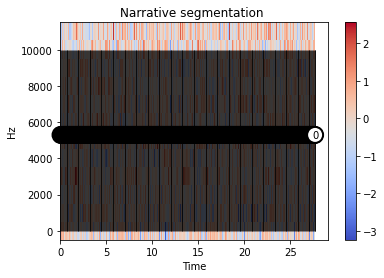

In [5]:
narr_len = len(narr_frames)

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr

sig_figs = 3

print(f"Sample rate = {sr}")
print(f"Frame Width = {round(1000*w,sig_figs)} ms")
print(f"Clip length = {round(w*narr_len,sig_figs)} s")
even_segmentation = get_even_segments(narr_len,frame_w=w,seg_ms=100)
print(f"Number of segments: {len(even_segmentation)}")

plot_segments_on_mfcc(np.transpose(narr_frames),even_segmentation,sr,title=f"Narrative segmentation ",line_color='black')

#### Bouquet


In [6]:
narr_bouquet = get_bouquet(even_segmentation,n_iter=[2,5],text_method = 'count')
print(f'Number of intervals in bouquet = {len(narr_bouquet)}')
for i in [1,2,3,4,5]:
    print(f'Number of {i}-segment intervals = {len([s for s in narr_bouquet if s["text"] == str(i)])}')

Number of intervals in bouquet = 551
Number of 1-segment intervals = 0
Number of 2-segment intervals = 277
Number of 3-segment intervals = 0
Number of 4-segment intervals = 0
Number of 5-segment intervals = 274


#### Split MFCC

In [9]:
split_mfcc = split_frames(narr_bouquet,narr_frames)
print(len(split_mfcc))
j = 1
for i,(interval,mfcc) in enumerate(zip(narr_bouquet,split_mfcc)):
    if interval["text"] == str(int(j)):
        plot_mfcc(np.transpose(mfcc),title=f'interval #{i+1}: \"{interval["text"]}\" ',sr= clip_data["sr"])
        j += 0.5
    if j > 3:
        pass
        #break

#split_fourier = split_frames(segmentation,np.transpose(word_data["fourier"]))

551


## Comparing to a Bouqet

In [10]:
narr_mfcc = split_mfcc[280]
word_mfcc_1 = clip_dict["Buy"]["frames"]
word_mfcc_2 = clip_dict["Sigh"]["frames"]
word_mfcc_3 = clip_dict["Bid"]["frames"]
print(dtw(word_mfcc_1,word_mfcc_1))
print(dtw(word_mfcc_1,narr_mfcc))
print(dtw(word_mfcc_1,word_mfcc_2))
print(dtw(word_mfcc_1,word_mfcc_3))

0.0
46.062891410020285
25.456765992929448
38.689126701096235


In [11]:
score_data = []
for word in clip_dict.keys():
    word_frames = clip_dict[word]["frames"]
    score = recurrence_score(word_frames,split_mfcc)
    length = word_frames.shape[0]*w
    score_data.append((length,score))
    print(f'Recurrence score: {round(score,3)},Length: {round(length,3)}, Word: {word}')

Recurrence score: 0.234,Length: 0.586, Word: Bird
Recurrence score: 0.308,Length: 0.517, Word: Bed
Recurrence score: 0.303,Length: 0.528, Word: Bid
Recurrence score: 0.269,Length: 0.67, Word: Above
Recurrence score: 0.283,Length: 0.517, Word: Bayed
Recurrence score: 0.329,Length: 0.531, Word: Good
Recurrence score: 0.303,Length: 0.499, Word: Buy
Recurrence score: 0.318,Length: 0.499, Word: Bud
Recurrence score: 0.226,Length: 0.601, Word: Bead
Recurrence score: 0.304,Length: 0.514, Word: Bough
Recurrence score: 0.261,Length: 0.639, Word: Bad
Recurrence score: 0.242,Length: 0.578, Word: Boy
Recurrence score: 0.289,Length: 0.566, Word: Booed
Recurrence score: 0.329,Length: 0.546, Word: Bode
Recurrence score: 0.278,Length: 0.601, Word: Pod
Recurrence score: 0.25,Length: 0.65, Word: Sigh
Recurrence score: 0.211,Length: 0.734, Word: Shy
Recurrence score: 0.304,Length: 0.583, Word: Fie
Recurrence score: 0.213,Length: 0.636, Word: Rye
Recurrence score: 0.313,Length: 0.485, Word: Die
Recurrence

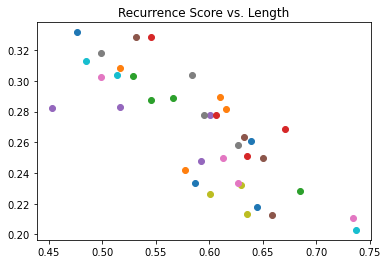

In [12]:
fig, ax = plt.subplots()
for length,score in score_data[:-2]:
    ax.scatter(length,score)
    title = ax.set(title="Recurrence Score vs. Length")